In [7]:
import os
from sys import getsizeof
from time import sleep
import json
import re
import inspect
from concurrent.futures import ProcessPoolExecutor
from warnings import filterwarnings

import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration,
	GPT2TokenizerFast
)
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from dotenv import load_dotenv
import openai

from utils.helpers import *
from utils.encoders import *
from utils.pipelines import *
from utils.trainer_utils import *
from utils.evaluator_utils import *

In [9]:
inf = float("inf")
filterwarnings("ignore")
load_dotenv()

True

In [3]:
data_dir = "/Users/naman/Workspace/Data/Long-Document-Summarization"
data_dir = "/home/nchibbar/Data"

crs_files = os.listdir(crs_dir := f"{data_dir}/GovReport/crs")
gao_files = os.listdir(gao_dir := f"{data_dir}/GovReport/gao")

print(f"crs files: {len(crs_files)}, gao files: {len(gao_files)}")

out_dir = f"{data_dir}/GovReport/processed"

crs files: 7238, gao files: 12228


In [4]:
# Sentence transformer
sent_dir = f"{data_dir}/Models/Sent-Transformer"
sent_encoder = SentenceTransformer(sent_dir)

# BART
bart_dir = f"{data_dir}/Models/BART"
bart_fine_tuned = f"{data_dir}/Models/BART-GovReport-SentenceSampler"
bart_tokenizer = BartTokenizer.from_pretrained(bart_dir)
bart_model = BartForConditionalGeneration.from_pretrained(bart_fine_tuned)
bart_context_size = bart_model.config.max_position_embeddings

# T5
t5_dir = f"{data_dir}/Models/T5"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_dir)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_dir)
t5_context_size = t5_model.config.n_positions

# GPT 3.5 turbo tokenizer
gpt_dir = f"{data_dir}/Models/GPT-3.5-turbo-tokenizer"
gpt_tokenizer = GPT2TokenizerFast.from_pretrained(gpt_dir)
gpt_model = "gpt-3.5-turbo"
gpt_context_size = 4096

bart_context_size, t5_context_size

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(1024, 4096)

In [5]:
preprocessor = TextProcessor(preprocessing=True)
postprocessor = None

## GovReport

In [ ]:
def combine_subsections(sections):
	text = ""
	for sec in sections:
		sec_text = "\n\n".join(sec["paragraphs"])
		if sec["section_title"]:
			sec_text = f"Section {sec["section_title"]}:\n\n{sec_text}"
		text = f"{text}\n\n{sec_text}" if text else sec_text
		if sec["subsections"]:
			sub_text = combine_subsections(sec["subsections"])
			text = f"{text}\n\n{sub_text}" if text else sub_text
	return text

In [ ]:
num_crs_files = len(crs_files)
for i, file in enumerate(crs_files):
	full_path = os.path.join(crs_dir, file)
	with open(full_path) as fp:
		data = json.load(fp)
	clear_stdout()
	print(f"{num_crs_files - i} files left", end="")
	text = f"{data["title"]}\n\n"
	text += combine_subsections([data["reports"]])
	summary = " ".join(data["summary"])
	summary = preprocessor.process(summary)
	with open(f"{out_dir}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

In [ ]:
for file in gao_files:
	file = os.path.join(gao_dir, file)
	with open(file) as fp:
		data = json.load(fp)
	text = combine_subsections(data["report"])
	text = preprocessor.process(text)
	print(data["highlight"])
	summary = "\n".join(data["highlight"])
	summary = preprocessor.process(summary)
	with open(f"{out_dir}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

## LDA

In [ ]:
vectorizer = CountVectorizer(stop_words="english")
vectorizer

In [ ]:
dtm = vectorizer.fit_transform([data["text"]])
vectorizer

In [ ]:
print(dtm)

In [ ]:
topics = 4
lda = LatentDirichletAllocation(n_components=topics)
lda.fit(dtm)

In [ ]:
topic_dist = lda.transform(dtm)
print(topic_dist)

In [ ]:
def display_topics(model, feature_names, num_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print(f"Topic {topic_idx}:")
		print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

## Rough

In [ ]:
texts, summaries = [], []

In [ ]:
# max 73_791
min_words_text = 70_000
for file in crs_files:
	with open(f"{out_dir}/{file}") as fp:
		data = json.load(fp)
	if count_words(data["text"]) >= min_words_text:
		break
texts.append(data["text"])
summaries.append(data["summary"])

count_words(data["text"]), count_words(data["summary"])

In [11]:
min_words = 4_000
max_words = 20_000
max_texts = 30
texts, summaries = [], []
num_texts = 0
for file in crs_files:
	with open(f"{out_dir}/{file}") as fp:
		data = json.load(fp)
	if min_words < count_words(data["text"]) < max_words:
		texts.append(data["text"])
		summaries.append(data["summary"])
		num_texts += 1
	if num_texts == max_texts:
		break

len(texts)

30

In [7]:
segment_min_words = 20
sent_segmenter = TextSegmenter(nltk.sent_tokenize, segment_min_words)

In [8]:
min_summary_tokens = 400
head_size = .5
threshold = .7
seed = 69
device = get_device()
device = "cpu"
system_prompt = "You will be given some segments of a very long document. Your task is to summarize the entire document as a whole by extracting key information and ideas from the segments. Generate a detailed, concise, and coherent summary in 500 words. Do not refer to the document in the summary in any way."

bart_encoders = [
	TruncateMiddle(
		bart_tokenizer, bart_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		bart_tokenizer, bart_context_size, sent_segmenter, preprocessor,
		True, seed
	),
	SentenceSampler(
		bart_tokenizer, bart_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	),
	RemoveRedundancy(
		bart_tokenizer, bart_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	)
]
t5_encoders = [
	TruncateMiddle(
		t5_tokenizer, t5_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		t5_tokenizer, t5_context_size, sent_segmenter, preprocessor,
		True, seed
	),
	SentenceSampler(
		t5_tokenizer, t5_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	),
	RemoveRedundancy(
		t5_tokenizer, t5_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	)
]
gpt_encoders = [
	TruncateMiddle(
		gpt_tokenizer, gpt_context_size, head_size, preprocessor, True
	),
	UniformSampler(
		gpt_tokenizer, gpt_context_size, sent_segmenter, preprocessor,
		True, seed
	),
	SentenceSampler(
		gpt_tokenizer, gpt_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	),
	RemoveRedundancy(
		gpt_tokenizer, gpt_context_size, sent_segmenter, sent_encoder,
		preprocessor, True, device=device, seed=seed
	)
]
bart_pipelines = [
	SummarizationPipeline(
		bart_model, enc, min_summary_tokens, bart_context_size,
		postprocessor, device
	) for enc in bart_encoders
]
t5_pipelines = [
	SummarizationPipeline(
		t5_model, enc, min_summary_tokens, t5_context_size,
		postprocessor, device
	) for enc in t5_encoders
]
gpt_pipelines = [
	OpenAIPipeline(
		gpt_model, enc, gpt_context_size
	) for enc in gpt_encoders
]
pipelines = bart_pipelines + t5_pipelines

In [ ]:
batch_size = 3
num_workers = min(len(pipelines), os.cpu_count())
num_workers = 0

evaluator = Evaluator(pipelines, num_workers, device)
results = evaluator(texts, summaries, batch_size)
results

In [12]:
word_counts = []
summary_word_counts = []

for file in crs_files:
	with open(f"{out_dir}/{file}") as fp:
		data = json.load(fp)
	word_counts.append(count_words(data["text"]))
	summary_word_counts.append(count_words(data["summary"]))

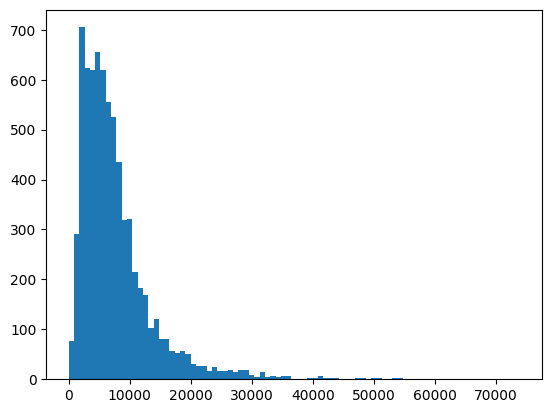

In [19]:
bins = int(len(word_counts) ** .5)
plt.hist(word_counts, bins=bins)
plt.show()